In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


PATH = "biolog_data.txt"
all_data = pd.read_csv(PATH, comment="<", encoding='cp1252', delimiter="\t")
all_data

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3066 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.74,Blattner Laboratory
1,b3072 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.89,Blattner Laboratory
2,b3076 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.07,Blattner Laboratory
3,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.78,Blattner Laboratory
4,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.43,Blattner Laboratory
...,...,...,...,...,...
100907,b4129 mutant Biolog assay,OD600 growth,Xylitol,0.19,Blattner Laboratory
100908,b4138 mutant Biolog assay,OD600 growth,Xylitol,0.22,Blattner Laboratory
100909,b4173 mutant Biolog assay,OD600 growth,Xylitol,0.15,Blattner Laboratory
100910,b4174 mutant Biolog assay,OD600 growth,Xylitol,0.15,Blattner Laboratory


# Screen replicated and single experiments

In [2]:
print("Unique locus number: ", len(set(all_data['Experiment Description'])))
print("Unique conditions number: ", len(set(all_data['Well Substrate'])))

Unique locus number:  212
Unique conditions number:  390


In [5]:
replicated_experiments = []
single_experiments = []
replicated_mutants = []
single_mutants = []
replicated_cond_locus_pairs = []
single_cond_locus_pairs = []

unique_mutants = set(all_data['Experiment Description'])
for mutant in tqdm(unique_mutants):
    locus = mutant.split(" ")[0]
    mutant_data = all_data[all_data["Experiment Description"] == mutant]
    mutant_unique_conditions = set(mutant_data["Well Substrate"])
    for mutant_unique_cond in mutant_unique_conditions:
        mutant_unique_cond_data = mutant_data[mutant_data["Well Substrate"] == mutant_unique_cond]
        if len(mutant_unique_cond_data) > 1:
            replicated_experiments.append(mutant_unique_cond_data)
            replicated_mutants.append(locus)
            replicated_cond_locus_pairs.append((mutant_unique_cond, locus))
        else:
            single_experiments.append(mutant_unique_cond_data)
            single_mutants.append(locus)
            single_cond_locus_pairs.append((mutant_unique_cond, locus))

100%|██████████| 212/212 [00:19<00:00, 11.06it/s]


In [6]:
# Check we have screened all data
sum([len(x) for x in replicated_experiments]) + len(single_cond_locus_pairs)

100912

# Screen metabolic genes (present in iML1515)

In [7]:
xp_descriptions = all_data['Experiment Description']
unique_genes = list(set([xp_desc.split(' ')[0] for xp_desc in xp_descriptions]))

In [8]:
import cobra
cobra_model = cobra.io.read_sbml_model("iML1515.xml")
genes_names_cobra_model = [x.id for x in cobra_model.genes]
duplicated_cobra_model = cobra.io.read_sbml_model("iML1515_duplicated.xml")

In [9]:
metabolic_genes_to_iML1515_reac_ids = {}
unique_reaction_KO_combs = []

for gene in unique_genes:
    if gene in genes_names_cobra_model:
        print("The gene " + gene + " is directly in the cobra model (metabolic gene).")
        print("It involves these reactions: ")
        involved_reactions = cobra_model.genes[genes_names_cobra_model.index(gene)].reactions
        print([reac.name for reac in involved_reactions])
        metabolic_genes_to_iML1515_reac_ids[gene] = []
        for reac in involved_reactions:
            metabolic_genes_to_iML1515_reac_ids[gene].append(reac.id)
        if metabolic_genes_to_iML1515_reac_ids[gene] not in unique_reaction_KO_combs:
            unique_reaction_KO_combs.append(metabolic_genes_to_iML1515_reac_ids[gene])
    else:
        print("\n")
        print(gene + " no match in iML1515")
        print("\n")

metabolic_genes_to_iML1515_reac_ids

The gene b4138 is directly in the cobra model (metabolic gene).
It involves these reactions: 
['Succinate:aspartate antiporter (periplasm)', 'Malate transport via proton symport (3 H) (periplasm)', 'Fumarate transport via proton symport (3 H) (periplasm)', 'Succinate:fumarate antiporter (periplasm)', 'Succinate:malate antiporter (periplasm)', 'Succintate transport via proton symport (3 H) (periplasm)', 'L-asparate transport via proton symport (3 H) (periplasm)']


b3244 no match in iML1515


The gene b3945 is directly in the cobra model (metabolic gene).
It involves these reactions: 
['Aminopropanol dehydrogenase reversible', 'Glycerol dehydrogenase', 'D-Lactaldehyde:NAD+ 1-oxidoreductase', 'Aldose reductase (acetol)']
The gene b4090 is directly in the cobra model (metabolic gene).
It involves these reactions: 
['Ribose-5-phosphate isomerase', 'Allose 6-phosphate isomerase']
The gene b3992 is directly in the cobra model (metabolic gene).
It involves these reactions: 
['Thiazole phospha

{'b4138': ['SUCASPtpp',
  'MALt2_3pp',
  'FUMt2_3pp',
  'SUCFUMtpp',
  'SUCMALtpp',
  'SUCCt2_3pp',
  'ASPt2_3pp'],
 'b3945': ['APPLDHr', 'GLYCDx', 'LALDO2x', 'ALR4x'],
 'b4090': ['RPI', 'ALLPI'],
 'b3992': ['THZPSN3'],
 'b3565': ['XYLI2', 'XYLI1'],
 'b3917': ['SULabcpp', 'SELabcpp', 'SLNTabcpp', 'TSULabcpp', 'MOBDabcpp'],
 'b3542': ['ALAALAabcpp', 'PROGLYabcpp', 'CGLYabcpp'],
 'b3600': ['M1PD'],
 'b3093': ['GALURt2rpp', 'GLCURt2rpp'],
 'b3909': ['GLCURt2rpp', 'DDGLCNt2rpp'],
 'b3857': ['BMOGDS1', 'MOGDS', 'BWCOGDS2', 'BMOGDS2', 'BWCOGDS1'],
 'b3416': ['AMALT1', 'AMALT4', 'AMALT2', 'AMALT3'],
 'b3132': ['TGBPA'],
 'b3919': ['TPI'],
 'b3991': ['TYRL'],
 'b3429': ['GLCS1'],
 'b3571': ['AAMYLpp'],
 'b3925': ['FBP'],
 'b3867': ['CPPPGO2'],
 'b3517': ['GLUDC'],
 'b3725': ['PIuabcpp'],
 'b4173': ['NTP3'],
 'b4071': ['NTRIR4pp', 'NTRIR3pp'],
 'b4111': ['GLYBt2pp', 'CRNDt2rpp', 'CTBTt2rpp', 'PROt2rpp', 'CRNt2rpp'],
 'b3437': ['GNK'],
 'b3930': ['DHNAOT4'],
 'b3603': ['L_LACt2rpp', 'GLYCLTt2rpp

In [10]:
print(len(unique_reaction_KO_combs))

103


In [8]:
all_reactions_dup = [reac for reac in duplicated_cobra_model.reactions]
all_reac_names_dup = [reac.name for reac in all_reactions_dup]
all_reac_ids_dup = [reac.id for reac in all_reactions_dup]

In [9]:
# need to correct the reaction ids names since some are duplicated

metabolic_genes_to_iML1515_DUPLICATED_reac_ids = {}

for gene_id in metabolic_genes_to_iML1515_reac_ids.keys():
    metabolic_genes_to_iML1515_DUPLICATED_reac_ids[gene_id] = []
    for reac_id in metabolic_genes_to_iML1515_reac_ids[gene_id]:
        for dup_reac_id in all_reac_ids_dup:
            if dup_reac_id.startswith(reac_id) and (dup_reac_id.endswith('_for') or dup_reac_id.endswith('_rev') or dup_reac_id.endswith('_i') or dup_reac_id.endswith('_o')):
                metabolic_genes_to_iML1515_DUPLICATED_reac_ids[gene_id].append(dup_reac_id)

            if dup_reac_id == reac_id:
                metabolic_genes_to_iML1515_DUPLICATED_reac_ids[gene_id].append(reac_id)

metabolic_genes_to_iML1515_DUPLICATED_reac_ids

{'b3416': ['AMALT1', 'AMALT3', 'AMALT4', 'AMALT2'],
 'b3751': ['RIBabcpp'],
 'b3543': ['ALAALAabcpp', 'CGLYabcpp', 'PROGLYabcpp'],
 'b3551': ['BSORx', 'METSOXR1', 'BSORy'],
 'b4117': ['ARGDC'],
 'b3456': ['VALabcpp', 'ALAabcpp', 'LEUabcpp', 'THRabcpp', 'ILEabcpp'],
 'b3860': ['DSBAO1', 'DSBAO2'],
 'b3396': ['MCTP1App', 'MPTG', 'MCTP2App', 'MPTG2'],
 'b3721': ['AB6PGH', 'BGLA1'],
 'b4041': ['G3PAT140',
  'G3PAT160',
  'G3PAT180',
  'G3PAT161',
  'G3PAT181',
  'G3PAT120',
  'G3PAT141'],
 'b3430': ['GLGC'],
 'b3924': ['RNTR4c2', 'RNTR2c2', 'FLDR2', 'RNTR3c2', 'RNTR1c2'],
 'b3091': ['ALTRH'],
 'b3831': ['PYNP2r_for', 'PYNP2r_rev'],
 'b4006': ['IMPC_for', 'IMPC_rev', 'AICART_for', 'AICART_rev'],
 'b3172': ['ARGSS'],
 'b3454': ['VALabcpp', 'ALAabcpp', 'LEUabcpp', 'THRabcpp', 'ILEabcpp'],
 'b3224': ['ACNAMt2pp'],
 'b3925': ['FBP'],
 'b3429': ['GLCS1'],
 'b3992': ['THZPSN3'],
 'b3580': ['3KGK', 'XYLK2'],
 'b3870': ['GLNS'],
 'b3519': ['TREH'],
 'b3565': ['XYLI2_for', 'XYLI2_rev', 'XYLI1_for', 

In [10]:
nbr_metabolic_genes = len(metabolic_genes_to_iML1515_DUPLICATED_reac_ids) # 120 different metabolic genes
nbr_gene_reac_links = sum([len(metabolic_genes_to_iML1515_DUPLICATED_reac_ids[x]) for x in metabolic_genes_to_iML1515_DUPLICATED_reac_ids.keys()]) # total of 323 targeted reactions

unique_reactions_targets = []
for gene_id in metabolic_genes_to_iML1515_DUPLICATED_reac_ids.keys():
    unique_reactions_targets += metabolic_genes_to_iML1515_DUPLICATED_reac_ids[gene_id]
unique_reactions_targets = list(np.unique(unique_reactions_targets))

nbr_unique_reactions_targeted = len(unique_reactions_targets) # but only 279 different reactions

print(nbr_metabolic_genes, nbr_gene_reac_links, nbr_unique_reactions_targeted)
unique_reactions_targets

120 323 279


['14GLUCANabcpp',
 '3KGK',
 'AAMYLpp',
 'AB6PGH',
 'ACGK',
 'ACHBS',
 'ACLS',
 'ACNAMt2pp',
 'ACNML',
 'ACODA',
 'ACOTA_for',
 'ACOTA_rev',
 'ADCL',
 'ADNCYC',
 'AGPR_for',
 'AGPR_rev',
 'AICART_for',
 'AICART_rev',
 'ALAALAabcpp',
 'ALAabcpp',
 'ALDD2y',
 'ALDD3y',
 'ALLPI_for',
 'ALLPI_rev',
 'ALR4x',
 'ALTRH',
 'AMALT1',
 'AMALT2',
 'AMALT3',
 'AMALT4',
 'AMPMS2',
 'AP4AS',
 'APPLDHr_for',
 'APPLDHr_rev',
 'ARGDC',
 'ARGSS',
 'ARMEPNS',
 'ASPTA_for',
 'ASPTA_rev',
 'ASPt2_3pp',
 'ATPS4rpp_i',
 'ATPS4rpp_o',
 'BGLA1',
 'BMOGDS1',
 'BMOGDS2',
 'BSORx',
 'BSORy',
 'BWCOGDS1',
 'BWCOGDS2',
 'CAT',
 'CGLYabcpp',
 'CHRPL',
 'CPPPGO2',
 'CRNDt2rpp_i',
 'CRNDt2rpp_o',
 'CRNt2rpp_i',
 'CRNt2rpp_o',
 'CTBTt2rpp_i',
 'CTBTt2rpp_o',
 'DDGLCNt2rpp_i',
 'DDGLCNt2rpp_o',
 'DHAD1',
 'DHAD2',
 'DHNAOT4',
 'DSBAO1',
 'DSBAO2',
 'DXYLK',
 'D_LACt2pp_i',
 'D_LACt2pp_o',
 'F6PA_for',
 'F6PA_rev',
 'FBP',
 'FDH4pp',
 'FDH5pp',
 'FE2abcpp',
 'FEROpp',
 'FLDR2',
 'FUMt2_3pp',
 'G1PTT',
 'G3PAT120',
 'G3PAT

# Screen substrates in iML1515

In [11]:
unique_substrates_biolog = set(all_data["Well Substrate"])
unique_substrates_biolog

{'(-)Shikimic Acid',
 '(5) 4-Amino-Imidazole-4(5)-Carboxamide',
 '1,2-Propanediol',
 '1-Thio-b-D-Glucose',
 '2,3-Butanediol',
 '2,3-Butanone',
 '2-Aminoethanol',
 '2-Aminoethyl Phosphonic Acid',
 '2-Deoxy Adenosine',
 '2-Deoxy-D-Glucose 6-Phosphate',
 '2-Deoxy-D-Ribose',
 '2-Hydroxy Benzoic Acid',
 '2-Hydroxyethane Sulfonic Acid',
 '2’-Deoxy Adenosine',
 '2’-Deoxy Cytidine',
 '2’-Deoxy Guanosine',
 '2’-DeoxyInosine',
 '2’-Deoxyuridine',
 '3-0-b-D-Galacto-pyranosyl-D-Arabinose',
 '3-Hydroxy 2-Butanone',
 '3-Methyl Glucose',
 '4-Hydroxy Benzoic Acid',
 '5-Keto-D-Gluconic Acid',
 '6-Phospho-Gluconic Acid',
 'Acetamide',
 'Acetic Acid',
 'Acetoacetic Acid',
 'Adenine',
 'Adenosine',
 'Adenosine-2’,3’-cyclic monophosphate',
 'Adenosine-2’-monophosphate',
 'Adenosine-3’,5’-cyclic monophosphate',
 'Adenosine-3’-monophosphate',
 'Adenosine-5’-monophosphate',
 'Adonitol',
 'Agmatine',
 'Ala-Asp',
 'Ala-Gln',
 'Ala-Glu',
 'Ala-Gly',
 'Ala-His',
 'Ala-Leu',
 'Ala-Thr',
 'Allantoin',
 'Alloxan',
 

In [12]:
substrates_names_cobra_model = [x.name for x in cobra_model.reactions if x.id.startswith('EX')]
set(substrates_names_cobra_model)

{'(2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran exchange',
 '(R)-Glycerate exchange',
 '(R)-Pantothenate exchange',
 '(R)-Propane-1,2-diol exchange',
 '(S)-Propane-1,2-diol exchange',
 '(enterobacterial common antigen)x4 core oligosaccharide lipid A exchange',
 '1,4-alpha-D-glucan exchange',
 '1,5-Diaminopentane exchange',
 '1-O-methyl-Beta-D-glucuronate exchange',
 "2',3'-Cyclic AMP exchange",
 "2',3'-Cyclic CMP exchange",
 "2',3'-Cyclic GMP exchange",
 "2',3'-Cyclic UMP exchange",
 '2(alpha-D-Mannosyl)-D-glycerate exchange',
 '2,3-Dihydroxypropane-1-sulfonate exchange',
 '2,3-diaminopropionate exchange',
 '2-Dehydro-3-deoxy-D-gluconate exchange',
 '2-Deoxy-D-glucose exchange',
 '2-Oxoglutarate exchange',
 "3'-AMP exchange",
 "3'-GMP exchange",
 "3'-UMP exchange",
 "3'-cmp exchange",
 '3,4-Dihydroxyphenylacetaldehyde exchange',
 '3-(3-hydroxy-phenyl)propionate exchange',
 '3-Hydroxypropanoate exchange',
 '3-hydroxycinnamic acid exchange',
 '4-Aminobutanoate exchange',
 '4-Hydro

In [13]:
from difflib import SequenceMatcher
# import jellyfish

# First, screen clear hits (exact match) between biolog substrate name and iML1515 exchange reaction name

biolog_sub_to_iML1515_sub_clear_hit = {}

for biolog_sub in unique_substrates_biolog:
    for cobra_sub in substrates_names_cobra_model:
        if biolog_sub == cobra_sub[:-9]:
            # print("CLEAR HIT")
            # print("biolog: ", biolog_sub, "cobra: ", cobra_sub[:-9])
            biolog_sub_to_iML1515_sub_clear_hit[biolog_sub] = [cobra_sub]
            break

In [14]:
biolog_sub_to_iML1515_sub_clear_hit

{'Ethanolamine': ['Ethanolamine exchange'],
 'Hypoxanthine': ['Hypoxanthine exchange'],
 'L-Threonine': ['L-Threonine exchange'],
 'Cytosine': ['Cytosine exchange'],
 'L-Rhamnose': ['L-Rhamnose exchange'],
 'L-Asparagine': ['L-Asparagine exchange'],
 'D-Xylose': ['D-Xylose exchange'],
 'Thymidine': ['Thymidine exchange'],
 'Maltose': ['Maltose exchange'],
 'L-Leucine': ['L-Leucine exchange'],
 'L-Proline': ['L-Proline exchange'],
 'Sucrose': ['Sucrose exchange'],
 'Guanosine': ['Guanosine exchange'],
 'D-Alanine': ['D-Alanine exchange'],
 'D-Cysteine': ['D-Cysteine exchange'],
 'Adenosine': ['Adenosine exchange'],
 'Uridine': ['Uridine exchange'],
 'Thymine': ['Thymine exchange'],
 'Putrescine': ['Putrescine exchange'],
 'Pyridoxine': ['Pyridoxine exchange'],
 'Xanthine': ['Xanthine exchange'],
 'Phosphate': ['Phosphate exchange'],
 'L-Lyxose': ['L-Lyxose exchange'],
 'Guanine': ['Guanine exchange'],
 'D-Mannitol': ['D-Mannitol exchange'],
 'D-Galactose': ['D-Galactose exchange'],
 'D-

In [18]:
# From next cells output, write a dictionary for unclear matching biolog substrate name with iML1515 substrate name.
# Sometimes 2 substrates present so the value associated to biolog substrate name (key) is a list
# Method: look for high similarity (jaro distance > 0.8) then add to dictionary, then look for less stringent distance (0.7, 0.6...)
biolog_sub_to_iML1515_sub_unclear_hit = {
    "L-Isoleucine +L-Valine": ["L-Isoleucine exchange", "L-Valine exchange"],
    "D-Cellobiose": ['Cellobiose exchange'],
    "Thiamine": ["Thiamin exchange"],
    "2’-Deoxy Cytidine": ["Deoxycytidine exchange"],
    "D-(+)-Glucose": ["D-Glucose exchange"],
    "Dihydroxy Acetone": ["Dihydroxyacetone exchange"],
    "2’-Deoxy Guanosine": ['Deoxyguanosine exchange'],
    "D-Melibiose": ["Melibiose exchange"],
    "D-Glucose-1-Phosphate": ["D-Glucose 1-phosphate exchange"],
    "D-Mannose-6-Phosphate": ["D-Mannose 6-phosphate exchange"],
    "2’-DeoxyInosine": ["Deoxyinosine exchange"],
    "N-Acetyl D-Glucosamine": ["N-Acetyl-D-glucosamine exchange"],
    "D-Glucose-6-Phosphate": ["D-Glucose 6-phosphate exchange"],
    "D,L-Carnitine": ["L-Carnitine exchange", "D-carnitine exchange"],
    "2-Deoxy Adenosine": ["Deoxyadenosine exchange"],
    "D-Biotin": ["Biotin exchange"],
    "N-Acetyl-D-Mannosamine": ["N-Acetyl-D-mannosamine exchange"],
    "O-Phospho-D-Tyrosine": ["Phosphotyrosine exchange"],
    "D-Fructose-6-Phosphate": ["D-fructose 6-phosphate exchange"],
    "b-D-Allose": ["D-Allose exchange"],
    "D-Trehalose": ["Trehalose exchange"],
    "D-Glucosamine-6-Phosphate": ["D-Glucosamine 6-phosphate exchange"],
    "O-Phospho-L-Serine": ["O-Phospho-L-serine exchange"],
    "L-Methionine Sulfoxide": ["L-Methionine S-oxide exchange"],
    "N-Acetyl-D-Galactosamine": ["N-Acetyl-D-galactosamine exchange"],
    "L-Ornithine": ["Ornithine exchange"],
    "2’-Deoxyuridine": ["Deoxyuridine exchange"],
    "D-Galacturonic Acid": ["D-Galacturonate exchange"],
    "a-D-Lactose": ["Lactose exchange"],
    "1,2-Propanediol": ["(S)-Propane-1,2-diol exchange", "(R)-Propane-1,2-diol exchange"],
    "D-Glucuronic Acid": ["D-Glucuronate exchange"],
    "D-Gluconic Acid": ["D-Gluconate exchange"],
    "Methane Sulfonic Acid": ["Methanesulfonate exchange"],
    "Inosine + Thiamine": ["Inosine exchange", "Thiamin exchange"],
    "Nicotinic Acid": ["Nicotinate exchange"],
    "Uridine-5’-monophosphate": ["Uridine exchange"],
    "L-Glutamic Acid": ["L-Glutamate exchange"],
    "Acetoacetic Acid": ["Acetoacetate exchange"],
    "Guanosine-5’-monophosphate": ["Guanosine exchange"],
    "Uridine-5’-monophosphate": ["Uridine exchange"],
    "Phosphono Acetic Acid": ["Phosphonate exchange"],
    "Butane Sulfonic Acid": ["Butanesulfonate exchange"],
    "L-Lactic Acid": ["L-Lactate exchange"],
    "N-Acetyl-Neuraminic Acid": ["N-Acetylneuraminate exchange"],
    "m-Inositol": ["Myo-Inositol exchange"],
    "Adenosine-5’-monophosphate": ["Adenosine exchange"],
    "Glycolic Acid": ["Glycolate exchange"],
    "Propionic Acid": ["Propionate exchange"],
    "Cytidine-5’-monophosphate": ["Cytidine exchange"],
    "Thymidine-5’-monophosphate": ["Thymidine exchange"],
    "L-Aspartic Acid": ["L-Aspartate exchange"],
    "D-Pantothenic Acid": ["(R)-Pantothenate exchange"],
    "(-)Shikimic Acid": ["Shikimate exchange"],
    "D-Malic Acid": ["D-Malate exchange"],
    "D,L-Malic Acid": ["D-Malate exchange", "L-Malate exchange"],
    "Fumaric Acid": ["Fumarate exchange"],
    "Pyruvic Acid": ["Pyruvate exchange"],
    "Glutathione (reduced form)": ["Reduced glutathione exchange"],
    "L-Malic Acid": ["L-Malate exchange"],
    "Butyric Acid": ["Butyrate (n-C4:0) exchange"],
    "Citric Acid": ["Citrate exchange"],
    "Acetic Acid": ["Acetate exchange"],
    "Formic Acid": ["Formate exchange"],
    "D-Tartaric Acid": ["D-tartrate exchange"],
    "L-Tartaric Acid": ["L-tartrate exchange"],
    "Met-Ala": ["L-Methionine exchange", "L-Alanine exchange"], 
    "Ala-Gly": ["L-Alanine exchange", "Glycine exchange"], 
    "Gly-Met": ["Glycine exchange", "L-Methionine exchange"], 
    "Gly-Glu": ["Glycine exchange", "L-Glutamate exchange"], 
    "Gly-Gln": ["Glycine exchange", "L-Glutamine exchange"], 
    "Gly-Asn": ["Glycine exchange", "L-Asparagine exchange"], 
    "Ala-Gln": ["L-Alanine exchange", "L-Glutamine exchange"], 
    "Ala-Glu": ["L-Alanine exchange", "L-Glutamate exchange"],
    "Ala-His": ["L-Alanine exchange", "L-Histidine exchange"],
    "Ala-Leu": ["L-Alanine exchange", "L-Leucine exchange"], 
    "Ala-Asp": ["L-Alanine exchange", "L-Aspartate exchange"],
    "Ala-Thr": ["L-Alanine exchange", "L-Threonine exchange"]
}

dropped_biolog_subs = ["b-Alanine", "D-Valine", "Spermine", "L-Alanyl-Glycine", "Maltitol", "Cysteamine", "O-Phospho-L-Threonine", "L-Homoserine Lactone",
                        "N-Acetyl-L-Cysteine", "L-Methionine Sulfone", "D,L-Ethionine", "a-D-Glucose", "N-Acetyl-D-Glucosamine", "N-Acetyl-b-D-Mannosamine",
                        "D-Fucose", "2’-Deoxy Adenosine", "D-Asparagine", "D-Threonine", "O-Phospho-D-Serine", "D-Lysine", "D-Arabitol", "Phosphocreatine", "Lactitol",
                        "D-Mannose-1-Phosphate", "Phenylethylamine", "DL-Carnitine", "D-Galactosamine", "Lanthionine", "D-Lyxose", "O-Phospho-L-Tyrosine",
                        "Lactulose", "L-Xylose", "D-Mannosamine", "L-Glucose", "D-Arabinose", "b-Phenylethylamine", "L-Alaninamide", "D.L-Octopamine", "Nicotinamide", "Hypotaurine",
                        "Acetamide", "D-Tagatose", "Turanose", "L-Arabitol", "b-Glycerol Phosphate", "L-Sorbose", "Palatinose", "Histamine", "Glutathione", "Pectin", "N-Butylamine",
                        "Hydroxylamine", "Glycogen", "D,L-Lactamide", "N-Acetyl-D,L-Methionine", "N-Acetyl-D,L-Methionine", "2-Deoxy-D-Glucose 6-Phosphate", "D-Raffinose", "Ethylamine",
                        "S-Methyl-L-Cysteine", "Phosphoryl Choline", "Phospho-L-Arginine", "a-Methyl-D-Galactoside", "Glycyl-L-Methionine", "Gentiobiose", "a-Methyl-D-Mannoside",
                        "Formamide", "L-Cysteine Sulfinic Acid", "Glucuronamide", "b-Methyl-D-Galactoside", "Methylamine", "Pyrophosphate", "2-Deoxy-D-Ribose", "b-Methyl-D-Glucoside",
                        "1-Thio-b-D-Glucose", "Menadione", "M-Hydroxy Phenyl Acetic Acid", "a-Hydroxy Butyric Acid", "Inulin", "D,L-a-Glycerol-Phosphate", "Guanosine-2’,3’-cyclic monophosphate",
                        "Itaconic Acid", "Citraconic Acid", "L-Cysteic Acid", "Trimetaphosphate", "D-Glutamic Acid",
                        "Laminarin", "Stachyose", "Thymidine-3’-monophosphate", "Tripolyphosphate", "N-Acetyl-L-Glutamic Acid", "Malonic Acid", "Tetrathionate",
                        "Alloxan", "L-Citrulline", "Uridine-3’,5’-cyclic monophosphate", "Inositol Hexaphosphate", "Guanosine-2’-monophosphate", "D-Glucosaminic Acid",
                        "D-Aspartic Acid", "Thiourea", "Uridine-2’-monophosphate", "b-Nicotinamide Adenine Dinucleotide", "Thiamine Pyrophosphate", "Cystathionine",
                        "L-Pyroglutamic Acid", "Quinic Acid", "Phosphoenol Pyruvate", "Adenosine-3’,5’-cyclic monophosphate", "Thiophosphate", "N-Amylamine",
                        "Guanosine-3’,5’-cyclic monophosphate", "D-Psicose", "2-Aminoethyl Phosphonic Acid", "4-Hydroxy Benzoic Acid", "Riboflavin", "3-Methyl Glucose",
                        "Dihydroxy Fumaric Acid", "Adenosine-2’-monophosphate", "Mannan", "g-Hydroxy Butyric Acid", "b-Methyl-D-Xyloside", "Adonitol", "Thymidine 3’,5’-cyclic monophosphate",
                        "Hypophosphite", "Uridine-3’-monophosphate", "Phospho-Glycolic Acid", "Adenosine-3’-monophosphate", "Dulcitol", "Hematin", "b-Hydroxy Pyruvic Acid",
                        "Ethylenediamine", "Cytidine-2’-monophosphate", "Cyano-Cobalamine", "L-Cysteinyl-Glycine", "Succinamic Acid", "Cytidine-3’,5’-cyclic monophosphate",
                        "Hydroxy-L-Proline", "Guanosine-3’-monophosphate", "Dithiophosphate", "Dextrin", "Sec-Butylamine", "Amygdalin", "Gelatin", "D-Galactonic Acid-g-Lactone",
                        "2-Hydroxy Benzoic Acid", "DL-Mevalonic Acid", "b-Hydroxy Butyric Acid", "Melibionic Acid", "Uridine-2’,3’-cyclic monophosphate", "Glycyl-L-Proline",
                        "Sedoheptulosan", "O-Phosphoryl-Ethanolamine", "Orotic Acid", "i-Erythritol", "D,L-a-Glycerol Phosphate", "Cytidine-2’,3’-cyclic monophosphate",
                        "3-Hydroxy 2-Butanone", "Methylene Diphosphonic Acid", "2,3-Butanone", "Citramalic Acid", "2-Aminoethanol", "Chorismic Acid", "L-Galactonic Acid-g-Lactone",
                        "Adenosine-2’,3’-cyclic monophosphate", "Cytidine-3’-monophosphate", "Triethyl Phosphate",
                        'Bromo Succinic Acid', 'Methyl Pyruvate', 'Oxalic Acid', 'Oxalomalic Acid', 'Pyrrolo-Quinoline Quinone', 'Biuret', 'a-Ketobutyric Acid', 'Tween 80',
                        'Xylitol', 'Tween 60', 'Mono Methyl Succinate', 'm-Tartaric Acid', 'D,L-Lipoamide', 'a-Amino-N-Valeric Acid', 'p-Hydroxy Phenyl Acetic Acid',
                        'Trans-4-Hydroxy L-Proline', 'Folic Acid', 'a-Keto-Butyric Acid', 'Cysteamine-S-Phosphate', 'DL-a-Hydroxy-Butyric Acid', 'Sebacic Acid',
                        'Tween 20', 'D,L-a-Amino-N-Butyric Acid', 'N-Phthaloyl-L-Glutamic Acid', 'p-Amino Benzene Sulfonic Acid', 'Capric Acid', 'Salicin',
                        'Uric Acid', 'D,L-a-Amino-Caprylic Acid', 'D-3-Phospho-Glyceric Acid', 'Parabanic Acid', 'D-Saccharic Acid', 'b-Methyl-D-Glucuronic Acid',
                        'd-Amino-N-Valeric Acid', 'Caproic Acid', '2-Hydroxyethane Sulfonic Acid', 'Taurocholic Acid', 'a-Keto-Glutaric Acid', '6-Phospho-Gluconic Acid',
                        'Glycyl-L-Glutamic Acid', 'b-Cyclodextrin', 'a-Hydroxy Glutaric Acid-g-Lactone', 'Tetramethylene Sulfone', 'a-Cyclodextrin', 'Chondroitin Sulfate C',
                        'd-Amino Valeric Acid', 'Oxaloacetic Acid', 'DL-a-Lipoic Acid (oxidized form)', 'Mucic Acid', 'D-2-Phospho-Glyceric Acid', 'Positive Control',
                        '3-0-b-D-Galacto-pyranosyl-D-Arabinose', 'Succinic Acid',
                        'g-Cyclodextrin', 'Tween 40', 'Negative Control', 'Quinolinic Acid', 'DL-Diamino-Pimelic Acid', 'p-Amino-Benzoic Acid', 'L-a -Phosphatidyl-D,L-Glycerol',
                        '5-Keto-D-Gluconic Acid', 'Glyoxylic Acid', 'e-Amino-N-Caproic Acid', '(5) 4-Amino-Imidazole-4(5)-Carboxamide', 'Caprylic Acid', '2,3-Butanediol',
                        'g-Amino-N-Butyric Acid', 'D-Lactic Acid Methyl Ester', 'Tricarballylic Acid', 'Deferoxamine Mesylate', 'Sorbic Acid', 'd-Amino-Levulinic Acid',
                        'L-Djenkolic Acid', 'Glycyl-L-Aspartic Acid', 'D-Ribono-1,4-Lactone', 'g-Amino Butyric Acid']

# Some substrates are doubled in the biolog dataset ==> remove one of the 2

Just observations here

In [18]:
all_data[all_data["Well Substrate"] == "a-D-Glucose"]
all_data[all_data["Well Substrate"] == "D-(+)-Glucose"]
# these two glucose forms have too different growth rate values, and only one exchange reaction in iML1515, I picked the D-(+)-glucose form for the final dataset

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
23956,b3066 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.85,Blattner Laboratory
23957,b3072 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.03,Blattner Laboratory
23958,b3076 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.10,Blattner Laboratory
23959,b3091 mutant Biolog assay,OD600 growth,D-(+)-Glucose,0.93,Blattner Laboratory
23960,b3093 mutant Biolog assay,OD600 growth,D-(+)-Glucose,0.97,Blattner Laboratory
...,...,...,...,...,...
24163,b4129 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.42,Blattner Laboratory
24164,b4138 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.81,Blattner Laboratory
24165,b4173 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.79,Blattner Laboratory
24166,b4174 mutant Biolog assay,OD600 growth,D-(+)-Glucose,1.83,Blattner Laboratory


In [19]:
all_data[all_data["Well Substrate"] == "N-Acetyl D-Glucosamine"]
# all_data[all_data["Well Substrate"] == "N-Acetyl-D-Glucosamine"]
# these two compounds have too different growth rate values, and only one exchange reaction in iML1515, I picked the first form for the final dataset since it contains 212 mutant data, no replicates

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
75260,b3066 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.83,Blattner Laboratory
75261,b3072 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.25,Blattner Laboratory
75262,b3076 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.20,Blattner Laboratory
75263,b3091 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,0.92,Blattner Laboratory
75264,b3093 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,0.97,Blattner Laboratory
...,...,...,...,...,...
75467,b4129 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.26,Blattner Laboratory
75468,b4138 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.89,Blattner Laboratory
75469,b4173 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.78,Blattner Laboratory
75470,b4174 mutant Biolog assay,OD600 growth,N-Acetyl D-Glucosamine,1.85,Blattner Laboratory


In [20]:
# all_data[all_data["Well Substrate"] == "2’-Deoxy Adenosine"]
all_data[all_data["Well Substrate"] == "2-Deoxy Adenosine"]
# these two compounds have too different growth rate values, and only one exchange reaction in iML1515, I picked the second form for the final dataset since the GR values seem more relevant

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
1696,b3066 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.46,Blattner Laboratory
1697,b3072 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.66,Blattner Laboratory
1698,b3076 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.70,Blattner Laboratory
1699,b3091 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.51,Blattner Laboratory
1700,b3093 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.44,Blattner Laboratory
...,...,...,...,...,...
1903,b4129 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.31,Blattner Laboratory
1904,b4138 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.62,Blattner Laboratory
1905,b4173 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.42,Blattner Laboratory
1906,b4174 mutant Biolog assay,OD600 growth,2-Deoxy Adenosine,1.27,Blattner Laboratory


In [21]:
# all_data[all_data["Well Substrate"] == "DL-Carnitine"]
all_data[all_data["Well Substrate"] == "D,L-Carnitine"]
# I kept D,L because it shows lower values of GR, we may want to try the other

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
22896,b3066 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.19,Blattner Laboratory
22897,b3072 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.17,Blattner Laboratory
22898,b3076 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.18,Blattner Laboratory
22899,b3091 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.17,Blattner Laboratory
22900,b3093 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.17,Blattner Laboratory
...,...,...,...,...,...
23103,b4129 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.18,Blattner Laboratory
23104,b4138 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.19,Blattner Laboratory
23105,b4173 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.19,Blattner Laboratory
23106,b4174 mutant Biolog assay,OD600 growth,"D,L-Carnitine",0.15,Blattner Laboratory


In [22]:
all_data[all_data["Well Substrate"] == "O-Phospho-L-Tyrosine"]
# all_data[all_data["Well Substrate"] == "O-Phospho-D-Tyrosine"]
# These two seem to have same kind of values but only one exchange reaction in iML1515 (Phosphotyrosine exchange), thus I picked the D form (randomly)

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
80984,b3743 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.67,Blattner Laboratory
80985,b3750 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.80,Blattner Laboratory
80986,b3751 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.97,Blattner Laboratory
80987,b3753 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.73,Blattner Laboratory
80988,b3771 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.15,Blattner Laboratory
...,...,...,...,...,...
81191,b3721 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.77,Blattner Laboratory
81192,b3725 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.80,Blattner Laboratory
81193,b3731 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.31,Blattner Laboratory
81194,b3740 mutant Biolog assay,OD600 growth,O-Phospho-L-Tyrosine,0.93,Blattner Laboratory


In [23]:
# all_data[all_data["Well Substrate"] == "Guanosine-2’-monophosphate"]
# all_data[all_data["Well Substrate"] == "Guanosine-3’-monophosphate"]
all_data[all_data["Well Substrate"] == "Guanosine-5’-monophosphate"]
# These two seem to have same kind of values but only one exchange reaction in iML1515 (guanosine exchange), thus I picked the 5' form (seem more canonical)

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
48548,b3743 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.88,Blattner Laboratory
48549,b3750 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.95,Blattner Laboratory
48550,b3751 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.73,Blattner Laboratory
48551,b3753 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.83,Blattner Laboratory
48552,b3771 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.15,Blattner Laboratory
...,...,...,...,...,...
48755,b3721 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,1.03,Blattner Laboratory
48756,b3725 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.87,Blattner Laboratory
48757,b3731 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.93,Blattner Laboratory
48758,b3740 mutant Biolog assay,OD600 growth,Guanosine-5’-monophosphate,0.76,Blattner Laboratory


In [24]:
# all_data[all_data["Well Substrate"] == "Uridine-2’-monophosphate"]
# all_data[all_data["Well Substrate"] == "Uridine-3’-monophosphate"]
all_data[all_data["Well Substrate"] == "Uridine-5’-monophosphate"]
# These seem to have same kind of values but only one exchange reaction in iML1515 (uridine exchange), thus I picked the 5' form (seem more canonical)

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
100064,b3743 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.55,Blattner Laboratory
100065,b3750 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.73,Blattner Laboratory
100066,b3751 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.99,Blattner Laboratory
100067,b3753 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.81,Blattner Laboratory
100068,b3771 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.17,Blattner Laboratory
...,...,...,...,...,...
100271,b3721 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.50,Blattner Laboratory
100272,b3725 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.57,Blattner Laboratory
100273,b3731 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.55,Blattner Laboratory
100274,b3740 mutant Biolog assay,OD600 growth,Uridine-5’-monophosphate,0.97,Blattner Laboratory


In [25]:
# all_data[all_data["Well Substrate"] == "Adenosine-2’-monophosphate"]
# all_data[all_data["Well Substrate"] == "Adenosine-3’-monophosphate"]
all_data[all_data["Well Substrate"] == "Adenosine-5’-monophosphate"]
# These two seem to have same kind of values but only one exchange reaction in iML1515 (Adenosine exchange), thus I picked the 5' form (seem more canonical)

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
10600,b3743 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.76,Blattner Laboratory
10601,b3750 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.71,Blattner Laboratory
10602,b3751 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.63,Blattner Laboratory
10603,b3753 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.91,Blattner Laboratory
10604,b3771 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.15,Blattner Laboratory
...,...,...,...,...,...
10807,b3721 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.83,Blattner Laboratory
10808,b3725 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.88,Blattner Laboratory
10809,b3731 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.69,Blattner Laboratory
10810,b3740 mutant Biolog assay,OD600 growth,Adenosine-5’-monophosphate,0.83,Blattner Laboratory


In [26]:
# all_data[all_data["Well Substrate"] == "Cytidine-2’-monophosphate"]
# all_data[all_data["Well Substrate"] == "Cytidine-3’-monophosphate"]
all_data[all_data["Well Substrate"] == "Cytidine-5’-monophosphate"]
# These two seem to have same kind of values but only one exchange reaction in iML1515 (Cytidine exchange), thus I picked the 5' form (seem more canonical)

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
21412,b3743 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.47,Blattner Laboratory
21413,b3750 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.74,Blattner Laboratory
21414,b3751 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.75,Blattner Laboratory
21415,b3753 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.53,Blattner Laboratory
21416,b3771 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.16,Blattner Laboratory
...,...,...,...,...,...
21619,b3721 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.46,Blattner Laboratory
21620,b3725 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.61,Blattner Laboratory
21621,b3731 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.50,Blattner Laboratory
21622,b3740 mutant Biolog assay,OD600 growth,Cytidine-5’-monophosphate,0.43,Blattner Laboratory


In [27]:
all_data[all_data["Well Substrate"] == "Negative Control"]
all_data[all_data["Well Substrate"] == "Positive Control"]
# Not keeping the negative control bc it shows growth (around 0.3) and positive control shows high growth >1.5 but no clue what is inside the medium

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
85224,b3066 mutant Biolog assay,OD600 growth,Positive Control,1.79,Blattner Laboratory
85225,b3072 mutant Biolog assay,OD600 growth,Positive Control,1.39,Blattner Laboratory
85226,b3076 mutant Biolog assay,OD600 growth,Positive Control,1.72,Blattner Laboratory
85227,b3091 mutant Biolog assay,OD600 growth,Positive Control,1.43,Blattner Laboratory
85228,b3093 mutant Biolog assay,OD600 growth,Positive Control,1.68,Blattner Laboratory
...,...,...,...,...,...
85431,b4129 mutant Biolog assay,OD600 growth,Positive Control,1.83,Blattner Laboratory
85432,b4138 mutant Biolog assay,OD600 growth,Positive Control,1.50,Blattner Laboratory
85433,b4173 mutant Biolog assay,OD600 growth,Positive Control,1.78,Blattner Laboratory
85434,b4174 mutant Biolog assay,OD600 growth,Positive Control,1.80,Blattner Laboratory


# Screen unclear hits with manual curation iterations, until all biolog substrates are cleared out

In [19]:
for biolog_sub in unique_substrates_biolog:
    if biolog_sub not in biolog_sub_to_iML1515_sub_clear_hit.keys():
        if biolog_sub not in biolog_sub_to_iML1515_sub_unclear_hit.keys():
            if biolog_sub not in dropped_biolog_subs:
                for cobra_sub in substrates_names_cobra_model:
                    # str_similarity = SequenceMatcher(None, biolog_sub, cobra_sub[:-9]).ratio()
                    # jaro_similarity = jellyfish.jaro_distance(biolog_sub, cobra_sub[:-9])
                    jaro_similarity = 1
                    if jaro_similarity > 0:
                        print("UNCLEAR HIT")
                        print("biolog: ", biolog_sub, "cobra: ", cobra_sub)
                        print(jaro_similarity)
                        print("\n")

# All biolog substrates have been cleared out if no output!

In [20]:
biolog_sub_to_iML1515_sub_all_hits = {**biolog_sub_to_iML1515_sub_clear_hit, **biolog_sub_to_iML1515_sub_unclear_hit}
print("We retrieved ", len(biolog_sub_to_iML1515_sub_all_hits.keys()), " biolog subtrates out of ", len(unique_substrates_biolog))

We retrieved  148  biolog subtrates out of  390


In [21]:
biolog_sub_to_iML1515_sub_all_hits

{'Ethanolamine': ['Ethanolamine exchange'],
 'Hypoxanthine': ['Hypoxanthine exchange'],
 'L-Threonine': ['L-Threonine exchange'],
 'Cytosine': ['Cytosine exchange'],
 'L-Rhamnose': ['L-Rhamnose exchange'],
 'L-Asparagine': ['L-Asparagine exchange'],
 'D-Xylose': ['D-Xylose exchange'],
 'Thymidine': ['Thymidine exchange'],
 'Maltose': ['Maltose exchange'],
 'L-Leucine': ['L-Leucine exchange'],
 'L-Proline': ['L-Proline exchange'],
 'Sucrose': ['Sucrose exchange'],
 'Guanosine': ['Guanosine exchange'],
 'D-Alanine': ['D-Alanine exchange'],
 'D-Cysteine': ['D-Cysteine exchange'],
 'Adenosine': ['Adenosine exchange'],
 'Uridine': ['Uridine exchange'],
 'Thymine': ['Thymine exchange'],
 'Putrescine': ['Putrescine exchange'],
 'Pyridoxine': ['Pyridoxine exchange'],
 'Xanthine': ['Xanthine exchange'],
 'Phosphate': ['Phosphate exchange'],
 'L-Lyxose': ['L-Lyxose exchange'],
 'Guanine': ['Guanine exchange'],
 'D-Mannitol': ['D-Mannitol exchange'],
 'D-Galactose': ['D-Galactose exchange'],
 'D-

In [22]:
all_reactions = [reac for reac in cobra_model.reactions]
all_reac_names = [reac.name for reac in all_reactions]
all_reac_ids = [reac.id for reac in all_reactions]

In [91]:
biolog_sub_to_iML1515_exchange_reactions = {}

for biolog_sub in biolog_sub_to_iML1515_sub_all_hits.keys():

    biolog_sub_to_iML1515_exchange_reactions[biolog_sub] = []

    corresp_iML1515_reac_names = biolog_sub_to_iML1515_sub_all_hits[biolog_sub]

    for reac_name in corresp_iML1515_reac_names:
        
        cobra_id = all_reac_ids[all_reac_names.index(reac_name)]

        # Get correct suffix for duplicated model
        if cobra_id.endswith("_i"):
            pass
        else:
            cobra_id += "_i"

        biolog_sub_to_iML1515_exchange_reactions[biolog_sub].append(cobra_id)

In [92]:
# Add succinate to dictionary biolog comp --> EX reactions, according to covert Supp Table

comp_with_succ = pd.read_csv("biolog_with_succinate.csv", index_col=0)
comp_with_succ = list(comp_with_succ.index)

for biolog_comp in biolog_sub_to_iML1515_exchange_reactions:
    if biolog_comp in comp_with_succ:
        biolog_sub_to_iML1515_exchange_reactions[biolog_comp].append("EX_succ_e_i")
        continue

In [93]:
all_ex_ids = []
for ex_ids in biolog_sub_to_iML1515_exchange_reactions.values():
    all_ex_ids += ex_ids

all_ex_ids = list(np.unique(all_ex_ids))

In [94]:
minmed_biologs_iML1515 = pd.read_csv("minmed_biologs_iML1515.csv").columns.to_list()

In [95]:
# remove exchange reactions which are in minmed (essential exchange reactions for iML1515)
for ex_id in minmed_biologs_iML1515:
    if ex_id in all_ex_ids:
        print("removing a minimal medium reaction in varmed: ", ex_id)
        all_ex_ids.remove(ex_id)

removing a minimal medium reaction in varmed:  EX_nh4_e_i
removing a minimal medium reaction in varmed:  EX_pi_e_i
removing a minimal medium reaction in varmed:  EX_so4_e_i


In [96]:
all_ex_ids

['EX_12ppd__R_e_i',
 'EX_12ppd__S_e_i',
 'EX_ac_e_i',
 'EX_acac_e_i',
 'EX_acgal_e_i',
 'EX_acgam_e_i',
 'EX_acmana_e_i',
 'EX_acnam_e_i',
 'EX_ade_e_i',
 'EX_adn_e_i',
 'EX_agm_e_i',
 'EX_ala__D_e_i',
 'EX_ala__L_e_i',
 'EX_all__D_e_i',
 'EX_alltn_e_i',
 'EX_arab__L_e_i',
 'EX_arbt_e_i',
 'EX_arg__L_e_i',
 'EX_asn__L_e_i',
 'EX_asp__L_e_i',
 'EX_btn_e_i',
 'EX_but_e_i',
 'EX_butso3_e_i',
 'EX_cellb_e_i',
 'EX_chol_e_i',
 'EX_cit_e_i',
 'EX_crn__D_e_i',
 'EX_crn_e_i',
 'EX_csn_e_i',
 'EX_cys__D_e_i',
 'EX_cys__L_e_i',
 'EX_cytd_e_i',
 'EX_dad_2_e_i',
 'EX_dcyt_e_i',
 'EX_dgsn_e_i',
 'EX_dha_e_i',
 'EX_din_e_i',
 'EX_duri_e_i',
 'EX_etha_e_i',
 'EX_f6p_e_i',
 'EX_for_e_i',
 'EX_fru_e_i',
 'EX_fuc__L_e_i',
 'EX_fum_e_i',
 'EX_g1p_e_i',
 'EX_g6p_e_i',
 'EX_gal_e_i',
 'EX_galur_e_i',
 'EX_gam6p_e_i',
 'EX_gam_e_i',
 'EX_glc__D_e_i',
 'EX_glcn_e_i',
 'EX_glcur_e_i',
 'EX_gln__L_e_i',
 'EX_glu__L_e_i',
 'EX_gly_e_i',
 'EX_glyc_e_i',
 'EX_glyclt_e_i',
 'EX_gsn_e_i',
 'EX_gthrd_e_i',
 'EX_gua_

# Build dataset of averaged replicated experiments, to keep because std < threshold (0.5)
## We also apply the constraint on metabolic gene and compatible condition

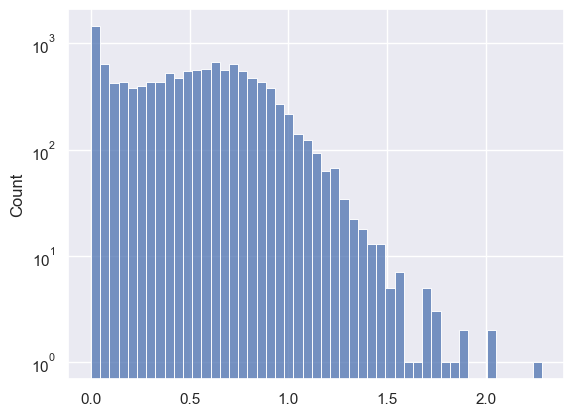

In [74]:
# plot histogram of std for rep. exps.
all_stds = []
for replicated_exp in replicated_experiments:
    all_stds.append(replicated_exp["Data Value"].std())
plt.close('all')
sns.set_theme()
sns.histplot(all_stds)
plt.yscale('log')
plt.show()

In [75]:
# Check-up that size is coherent
len(replicated_experiments) == len(replicated_cond_locus_pairs)

True

In [76]:
STD_THRESHOLD = 100
# forbidden_cond_locus_pairs = []
averaged_replicated_experiments = []

i = 0
for rep_xp in replicated_experiments:
    std = rep_xp["Data Value"].std()
    if std > STD_THRESHOLD:
        # forbidden_cond_locus_pairs.append(replicated_cond_locus_pairs[i])
        pass
    else:
        one_rep = rep_xp.iloc[0].copy()

        target_locus = one_rep["Experiment Description"].split(' ')[0]
        cond = one_rep["Well Substrate"]

        if cond in list(biolog_sub_to_iML1515_sub_all_hits.keys()):
            pass
        else:
            continue

        # Remove substrates essential to growth in iML1515 (always ON)
        to_skip = False
        corresp_ex_reac_ids = biolog_sub_to_iML1515_exchange_reactions[cond]
        for corresp_ex_reac_id in corresp_ex_reac_ids:
            if corresp_ex_reac_id in minmed_biologs_iML1515:
                to_skip = True
                break
        if to_skip:
            continue

        if target_locus in list(metabolic_genes_to_iML1515_reac_ids.keys()):
            pass
        else:
            continue

        mean_GR = rep_xp["Data Value"].mean()
        one_rep["Data Value"] = mean_GR
        averaged_replicated_experiments.append(one_rep)
    i += 1

# forbidden_conds = [x[0] for x in forbidden_cond_locus_pairs]
# forbidden_locus = [x[1] for x in forbidden_cond_locus_pairs]

averaged_replicated_experiments_df = pd.concat(averaged_replicated_experiments, axis=1).T

averaged_replicated_experiments_df

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
71708,b3415 mutant Biolog assay,OD600 growth,m-Inositol,0.69,Blattner Laboratory
68316,b3415 mutant Biolog assay,OD600 growth,L-Threonine,0.74,Blattner Laboratory
21676,b3415 mutant Biolog assay,OD600 growth,Cytosine,1.11,Blattner Laboratory
54324,b3415 mutant Biolog assay,OD600 growth,L-Asparagine,1.233333,Blattner Laboratory
92908,b3415 mutant Biolog assay,OD600 growth,Thymidine,0.816667,Blattner Laboratory
...,...,...,...,...,...
58745,b3225 mutant Biolog assay,OD600 growth,L-Glutamine,1.416667,Blattner Laboratory
65317,b3225 mutant Biolog assay,OD600 growth,L-Phenylalanine,0.763333,Blattner Laboratory
30655,b3225 mutant Biolog assay,OD600 growth,D-Glucose-6-Phosphate,1.31,Blattner Laboratory
60017,b3225 mutant Biolog assay,OD600 growth,L-Homoserine,0.335,Blattner Laboratory


In [77]:
len(set(averaged_replicated_experiments_df["Experiment Description"]))

120

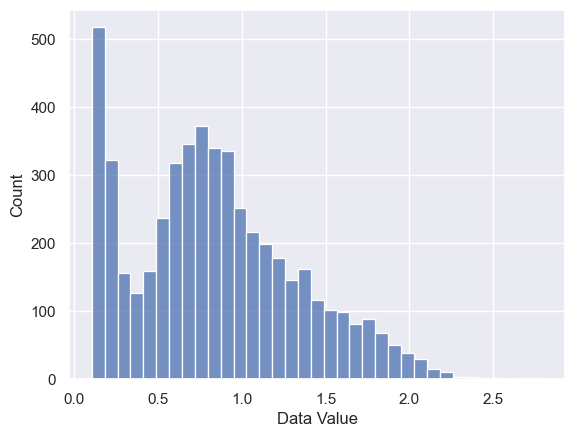

In [78]:
sns.histplot(averaged_replicated_experiments_df["Data Value"])
plt.show()

# Get indices to delete (replicated experiments, or non-metabolic gene, or non-compatible conditions)

In [79]:
all_data_copied = all_data.copy()
indices_to_del = []

for i in all_data.index:
    target_locus = all_data.iloc[i]["Experiment Description"]
    cond = all_data.iloc[i]["Well Substrate"]
    target_locus_name = target_locus.split(' ')[0]

    # Remove substrates not in iML1515
    if cond in list(biolog_sub_to_iML1515_sub_all_hits.keys()):
        pass
    else:
        indices_to_del.append(i)
        continue
    
    # Remove substrates essential to growth in iML1515 (always ON)
    corresp_ex_reac_ids = biolog_sub_to_iML1515_exchange_reactions[cond]
    for corresp_ex_reac_id in corresp_ex_reac_ids:
        if corresp_ex_reac_id in minmed_biologs_iML1515:
            indices_to_del.append(i)
            continue
    
    # Remove genes that are not in iML1515
    if target_locus_name in list(metabolic_genes_to_iML1515_reac_ids.keys()):
        pass
    else:
        indices_to_del.append(i)
        continue
    
    # add all indices for replicated experiments for deletion
    # then we'll add back the averaged ones for low stds only
    for rep_pair in replicated_cond_locus_pairs:
        rep_loc = rep_pair[1]
        rep_cond = rep_pair[0]
        if (rep_loc in target_locus) and (rep_cond == cond):
            indices_to_del.append(i)
            break

print(len(indices_to_del))

88897


In [80]:
all_data_single = all_data_copied.drop(index=indices_to_del)

In [81]:
len(set(all_data_single["Experiment Description"]))

120

In [82]:
all_data_final = pd.concat([all_data_single, averaged_replicated_experiments_df], ignore_index=True)
all_data_final

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.78,Blattner Laboratory
1,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.43,Blattner Laboratory
2,b3132 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.04,Blattner Laboratory
3,b3137 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.09,Blattner Laboratory
4,b3161 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.91,Blattner Laboratory
...,...,...,...,...,...
17395,b3225 mutant Biolog assay,OD600 growth,L-Glutamine,1.416667,Blattner Laboratory
17396,b3225 mutant Biolog assay,OD600 growth,L-Phenylalanine,0.763333,Blattner Laboratory
17397,b3225 mutant Biolog assay,OD600 growth,D-Glucose-6-Phosphate,1.31,Blattner Laboratory
17398,b3225 mutant Biolog assay,OD600 growth,L-Homoserine,0.335,Blattner Laboratory


In [83]:
print("Data number: ", len(all_data_final))
print("Unique locus number: ", len(set(all_data_final['Experiment Description'])))
print("Unique conditions number: ", len(set(all_data_final['Well Substrate'])))

Data number:  17400
Unique locus number:  120
Unique conditions number:  145


In [84]:
all_data_final.to_csv("biolog_metabolic_genes.csv")
all_data_single.to_csv("biolog_metabolic_genes_single_only.csv")

In [85]:
120*145 # when applying thershold on std, data points missing. ~2500 for final dataset.

17400

# Make AMN-suitable dataset

### The dataset is built as (from left to right):
- Minmed (24 exchange reactions) all ones
- Varmed (131 exchange reactions)
- Genes (120 genes)
- GR_AVG

In [86]:
all_data_final

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.78,Blattner Laboratory
1,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.43,Blattner Laboratory
2,b3132 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.04,Blattner Laboratory
3,b3137 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.09,Blattner Laboratory
4,b3161 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.91,Blattner Laboratory
...,...,...,...,...,...
17395,b3225 mutant Biolog assay,OD600 growth,L-Glutamine,1.416667,Blattner Laboratory
17396,b3225 mutant Biolog assay,OD600 growth,L-Phenylalanine,0.763333,Blattner Laboratory
17397,b3225 mutant Biolog assay,OD600 growth,D-Glucose-6-Phosphate,1.31,Blattner Laboratory
17398,b3225 mutant Biolog assay,OD600 growth,L-Homoserine,0.335,Blattner Laboratory


In [87]:
gene_ids = list(sorted(metabolic_genes_to_iML1515_DUPLICATED_reac_ids.keys()))

In [97]:
columns_amn_dataset = minmed_biologs_iML1515 + all_ex_ids + unique_reactions_targets + ['GR_AVG']
columns_amn_dataset

['EX_nh4_e_i',
 'EX_pi_e_i',
 'EX_co2_e_i',
 'EX_fe3_e_i',
 'EX_h_e_i',
 'EX_mn2_e_i',
 'EX_fe2_e_i',
 'EX_zn2_e_i',
 'EX_mg2_e_i',
 'EX_ca2_e_i',
 'EX_ni2_e_i',
 'EX_cu2_e_i',
 'EX_sel_e_i',
 'EX_cobalt2_e_i',
 'EX_h2o_e_i',
 'EX_mobd_e_i',
 'EX_so4_e_i',
 'EX_k_e_i',
 'EX_na1_e_i',
 'EX_cl_e_i',
 'EX_o2_e_i',
 'EX_tungs_e_i',
 'EX_slnt_e_i',
 'EX_12ppd__R_e_i',
 'EX_12ppd__S_e_i',
 'EX_ac_e_i',
 'EX_acac_e_i',
 'EX_acgal_e_i',
 'EX_acgam_e_i',
 'EX_acmana_e_i',
 'EX_acnam_e_i',
 'EX_ade_e_i',
 'EX_adn_e_i',
 'EX_agm_e_i',
 'EX_ala__D_e_i',
 'EX_ala__L_e_i',
 'EX_all__D_e_i',
 'EX_alltn_e_i',
 'EX_arab__L_e_i',
 'EX_arbt_e_i',
 'EX_arg__L_e_i',
 'EX_asn__L_e_i',
 'EX_asp__L_e_i',
 'EX_btn_e_i',
 'EX_but_e_i',
 'EX_butso3_e_i',
 'EX_cellb_e_i',
 'EX_chol_e_i',
 'EX_cit_e_i',
 'EX_crn__D_e_i',
 'EX_crn_e_i',
 'EX_csn_e_i',
 'EX_cys__D_e_i',
 'EX_cys__L_e_i',
 'EX_cytd_e_i',
 'EX_dad_2_e_i',
 'EX_dcyt_e_i',
 'EX_dgsn_e_i',
 'EX_dha_e_i',
 'EX_din_e_i',
 'EX_duri_e_i',
 'EX_etha_e_i',
 'E

In [98]:
len(columns_amn_dataset)

431

In [99]:
biolog_sub_to_iML1515_exchange_reactions

{'Ethanolamine': ['EX_etha_e_i'],
 'Hypoxanthine': ['EX_hxan_e_i'],
 'L-Threonine': ['EX_thr__L_e_i', 'EX_succ_e_i'],
 'Cytosine': ['EX_csn_e_i', 'EX_succ_e_i'],
 'L-Rhamnose': ['EX_rmn_e_i'],
 'L-Asparagine': ['EX_asn__L_e_i', 'EX_succ_e_i'],
 'D-Xylose': ['EX_xyl__D_e_i'],
 'Thymidine': ['EX_thymd_e_i', 'EX_succ_e_i'],
 'Maltose': ['EX_malt_e_i'],
 'L-Leucine': ['EX_leu__L_e_i', 'EX_succ_e_i'],
 'L-Proline': ['EX_pro__L_e_i', 'EX_succ_e_i'],
 'Sucrose': ['EX_sucr_e_i'],
 'Guanosine': ['EX_gsn_e_i', 'EX_succ_e_i'],
 'D-Alanine': ['EX_ala__D_e_i', 'EX_succ_e_i'],
 'D-Cysteine': ['EX_cys__D_e_i'],
 'Adenosine': ['EX_adn_e_i', 'EX_succ_e_i'],
 'Uridine': ['EX_uri_e_i', 'EX_succ_e_i'],
 'Thymine': ['EX_thym_e_i'],
 'Putrescine': ['EX_ptrc_e_i', 'EX_succ_e_i'],
 'Pyridoxine': ['EX_pydxn_e_i'],
 'Xanthine': ['EX_xan_e_i', 'EX_succ_e_i'],
 'Phosphate': ['EX_pi_e_i'],
 'L-Lyxose': ['EX_lyx__L_e_i'],
 'Guanine': ['EX_gua_e_i', 'EX_succ_e_i'],
 'D-Mannitol': ['EX_mnl_e_i'],
 'D-Galactose': ['EX

In [100]:
# Make the minmed part of the dataset, full of ones

minmed_df = np.ones((len(all_data_final), len(minmed_biologs_iML1515)))
minmed_df

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [101]:
# Make the varmed part

varmed_df = np.zeros((len(all_data_final), len(all_ex_ids)))

for i in all_data_final.index:
    sub = all_data_final.iloc[i]["Well Substrate"]
    corresp_ex_reacs = biolog_sub_to_iML1515_exchange_reactions[sub]
    for corresp_ex_reac in corresp_ex_reacs:
        index = all_ex_ids.index(corresp_ex_reac)
        varmed_df[i][index] = 1

# We see here the presence count for each compound, max is succinae (6360), alanine (1080), then some at 360 and 240. Most appear once, giving 120 occurences (120 target genes)
np.count_nonzero(varmed_df, axis=0)

array([ 120,  120,  120,  120,  120,  120,  120,  120,  120,  240,  120,
        120, 1080,  120,  120,  120,  120,  120,  240,  240,  120,  120,
        120,  120,  120,  120,  120,  120,  120,  120,  120,  240,  120,
        120,  120,  120,  120,  120,  120,  120,  120,  120,  120,  120,
        120,  120,  120,  120,  120,  120,  120,  120,  120,  360,  360,
        720,  120,  120,  240,  120,  120,  240,  120,  120,  240,  120,
        240,  120,  120,  240,  120,  120,  240,  240,  120,  120,  120,
        120,  120,  120,  360,  120,  120,  120,  120,  120,  120,  120,
        120,  120,  120,  120,  120,  120,  120,  120,  120,  120,  120,
        120,  120,  120,  120,  120,  120,  120, 6360,  120,  120,  120,
        120,  240,  240,  120,  240,  120,  120,  120,  120,  120,  120,
        120,  120,  240,  240,  120,  120,  120])

In [103]:
# Make the reactions targeted by gene KOs part: all 1s except if reaction is affected by KO ==> 0

gene_df = np.ones((len(all_data_final), len(unique_reactions_targets)))

for i in all_data_final.index:
    gene = all_data_final.iloc[i]["Experiment Description"].split(' ')[0]
    targeted_reactions = metabolic_genes_to_iML1515_DUPLICATED_reac_ids[gene]
    for targ_reac in targeted_reactions:
        index = unique_reactions_targets.index(targ_reac)
        gene_df[i][index] = 0

np.count_nonzero(gene_df, axis=1)

array([278, 275, 277, ..., 278, 278, 278])

In [104]:
GR_df = np.zeros((len(all_data_final), 1))

for i in all_data_final.index:
    GR = all_data_final.iloc[i]["Data Value"]
    GR_df[i][0] = GR

GR_df

array([[0.78      ],
       [1.43      ],
       [1.04      ],
       ...,
       [1.31      ],
       [0.335     ],
       [0.67666667]])

In [105]:
full_df = np.hstack((minmed_df, varmed_df, gene_df, GR_df))
full_df

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.78      ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.43      ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.04      ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.31      ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.335     ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.67666667]])

In [107]:
pd_full_df = pd.DataFrame(data=full_df, columns=columns_amn_dataset)

pd_full_df

,EX_nh4_e_i,EX_pi_e_i,EX_co2_e_i,EX_fe3_e_i,EX_h_e_i,EX_mn2_e_i,EX_fe2_e_i,EX_zn2_e_i,EX_mg2_e_i,EX_ca2_e_i,...,VPAMTr_for,VPAMTr_rev,XYLI1_for,XYLI1_rev,XYLI2_for,XYLI2_rev,XYLK,XYLK2,XYLabcpp,GR_AVG
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.780000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.430000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.040000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.090000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.910000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17395,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.416667
17396,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.763333
17397,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.310000
17398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.335000


In [108]:
pd_full_df.to_csv("biolog_iML1515_AMN.csv", index=False)